Приветствую того, кто читает этот код.В качестве научной работы в университете я занимаюсь спайковыми нейронными сетями. Основной библиотекой является brian2. Так как эта область довольно новая, каких-то готовых хороших алгоритмов для решения определенных задач практически нет, поэтому многое приходится делать методом проб и ошибок, а в этом очень сильно помогает визуализация данных и наш любимый matplotlib. 

В классических нейронных сетях простейшей задачей, с которой начинают новички является классификация mnist, но для спайковых сетей эта задача пока довольно сложная, поэтому в данной работе я покажу их работу на примере двухклассовой классификации датасета digits.

Кратко о спайковых нейронных сетях. Спайковый нейрон взят из биологии и представляет из себя элемент, который получает импульсы тока и накапливает потенциал на мембране. Когда потенциал превышает определенное значение нейрон передает импульс(спайк) к другим нейронам через связи, собственно веса связей между нейронами и подбираются в процессе обучения. В отличии от классических нейронных сетей, спайковые сети принимают на вход не одну картинку, а ряд из одной картинки, то есть они как бы смотрят на картинку втечение некоторого времени, заряжая мембраны нейронов. Так же между нейронами последнего слоя можно организовать конкуренцию за ток от входных нейронов, это позволяет ускорить обучение. Архитектура сети очень простая: входной слой по нейрону на каждый пиксель картинки и выходной слой 2 нейрона.

In [1]:
from brian2 import *
#%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
#Loading dataset Normalizing data to [0,1]
digits=datasets.load_digits(2)
data, y = (digits.images/16),digits.target

In [3]:
data.max()

1.0

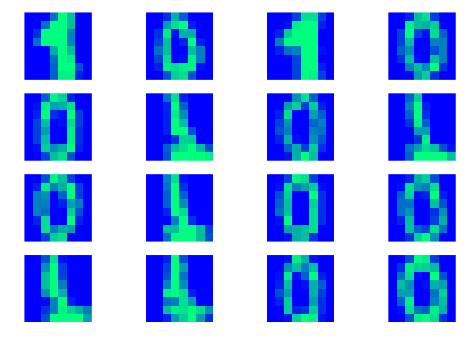

In [4]:
figure('data')
for j in np.arange(int(16)):
    subplot(4, 4, j+1)
    imshow(data[j+100].reshape(8, 8), cmap='winter', interpolation='None')
    axis('off')
    #print(y[j+100])
show()

data = data.reshape(-1, 64)

Задаем правила обучения сети и значения гиперпараметров. Спайковые сети описываются дифференциальными и алгебраическими уравнениями, определяющими взаимодействие нейронов и частоту спайкования, ещё тут довольно много гиперпараметров, которые нужно подбирать для нормального обучения.

In [5]:
start_scope()

n_input_width = 8.
n_input_height = n_input_width
n_input = n_input_width* n_input_height

n_hidden = 2

time_step = 0.1 * ms
alpha = 10 * ms
beta = 100 * ms
tau = 10*ms
tau_I = 15*ms
tau_h = 50*ms

wmax = 1.0
c_inp = 0.2
c_neg = 1.7  #8.8
lr = 0.05
lr_n = 0.01
decay = 0.001

eqs_input_neuron = '''
rates : Hz
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - theta: 1
train : 1
'''

eqs_hidden_neuron = '''
dv/dt = (-v+I)/tau : 1 (unless refractory)
dI_inp/dt = -I_inp/tau_I :1
dI_neg/dt = -I_neg/tau_I :1
I_teacher : 1
I = I_inp + I_neg + I_teacher :1
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - theta: 1
dhold/dt = -hold/tau_h : 1
train : 1
'''

reset_hidden = '''
v = 0
hold += 0.1 * n_hidden
'''

eqs_input_syn = '''
w : 1
'''

# equations that describe changes if presynaptic spike of the forward-oriented synapse of input layer occures
eqs_input_pre = '''
I_inp_post += w * c_inp
a_pre += 1./n_hidden *1*ms/(alpha)
theta_pre += 1./n_hidden *1*ms/(beta)
'''

# equations that describe changes if postsynaptic spike of the forward synapse occures
eqs_input_post = '''
a_post += 1./n_input *1*ms/(alpha)
theta_post += 1./n_input *1*ms/(beta)
w = clip(w + train_pre * (-decay + lr*diff_pre), 0, wmax)
'''

eqs_neg_syn = '''
w : 1
'''

# equations that describe changes if presynaptic spike of the forward-oriented synapse of input layer occures
eqs_neg_pre = '''
I_neg_post += w * c_neg
'''

#w = clip(w + train_pre*(+decay - lr_n * diff_post), -wmax, 0)

# equations that describe changes if postsynaptic spike of the forward synapse occures
eqs_neg_post = '''
w = clip(w + train_pre*(-lr_n*diff_pre), -wmax, 0)
'''

Инициализируем значения параметров сети, нейронные группы и связи между нейронами.

In [9]:
P = NeuronGroup(n_input, eqs_input_neuron, threshold='rand()<rates*dt', method='linear', refractory=2*ms, dt = time_step, name='P')
P.rates = [k*250*Hz for k in data[0]]
P.train = np.ones_like(P.train)
P.a = np.random.rand(len(P))*0.5
P.theta = np.random.rand(len(P))*0.5

StateMonitorP = StateMonitor(P, ['rates', 'a', 'theta', 'diff'], record=True)

G = NeuronGroup(n_hidden, eqs_hidden_neuron, method='linear', threshold='v > hold', reset=reset_hidden, refractory=2*ms, dt=time_step, name = 'G')
G.train = np.ones_like(G.train)
G.a = np.random.rand(len(G))*0.5
G.theta = np.random.rand(len(G))*0.5     
G.hold = np.ones_like(G.hold) * 3.

StateMonitorG = StateMonitor(G, ['a', 'I', 'diff', 'I_inp', 'I_neg', 'hold'], record=True)

S = Synapses(P, G, eqs_input_syn, on_pre=eqs_input_pre, on_post=eqs_input_post, dt=time_step)
S.connect()
S.w = np.random.rand(len(S))

StateMonitorS = StateMonitor(S, ['w'], record=True)

S_neg = Synapses(G, G, eqs_neg_syn, on_pre=eqs_neg_pre, on_post=eqs_neg_post, dt=time_step)
S_neg.connect('i!=j')
#S_neg.w = np.random.rand(len(S_neg)) * (-1.)
S_neg.w = np.ones_like(S_neg.w) * (-1.)

StateMonitorS_neg = StateMonitor(S_neg, ['w'], record=True)
print "im here"
predictions = []
labels = []
counter = 0
train = 1
@network_operation(dt=50*ms)
def update_input():
    global counter
    global train
    if counter % 2 == 0:
        
        #if counter:
         #   predictions.append(np.argmax(np.mean(StateMonitorG.a[:,-50:], axis=1)))
        
        index = np.random.randint(1,349)
        P.rates = [k*250*Hz for k in data[index]]
        if train:
            G.I_teacher = np.zeros_like(G.I_teacher)
            G.I_teacher[int(y[index])] = 100.0

        labels.append(int(y[index]))
    else:
        P.rates = np.zeros_like(P.rates)
        G.I_teacher = np.zeros_like(G.I_teacher)
        predictions.append(np.argmax(np.mean(StateMonitorG.a[:,-50:], axis=1)))
    counter += 1

run(10000*ms)
print "now here"
#add last prediction
#predictions.append(np.argmax(np.mean(StateMonitorG.a[:,-50:], axis=1)))

im here
now here


20000 милисекунд обучали сеть, посчитаем точность на трейне. Все хорошо, это единица!

In [10]:
from sklearn.metrics import accuracy_score

print accuracy_score(predictions, labels)

1.0


Посмотрим на веса нейронов входного слоя. Они действительно становятся похожи на 1 и 0 соответственно. Это здорово!

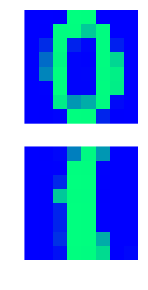

In [11]:
images_input = [[S.w[r + j * int(len(G))]
         for j in np.arange(len(P))] 
         for r in np.arange(len(G))]
images_input = np.array(images_input).reshape(int(n_hidden), int(n_input_width), int(n_input_height))


k=1
figure('input Weight visualisation', figsize=(5,5))
for image in images_input:
    subplot(3, 1, k)
    imshow(image, cmap='winter', interpolation='None')
    axis('off')

    k+=1

show()

In [15]:
import animation

In [24]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import math
global_j=0
global_jmax=0
global_step = 25
def animate_weights(G,P,StateMonitorS,end=10000,start=0,save=True,show=True,step = 25):
    print n_hidden
    """
    show(bool) : whether to show
    save(bool) : whether to save
    start(int) : start tick
    end(int) : end tick
    P,G : Neuron groups. Visualising weights from P to G
    StateMonitorS : brian state monitor adjusted to weights you want to visualise
    global_step(int) :global ticks from frame to next frame
    global_j(int) : global counter
    global_jmax : global, set to math.floor((end-start)/global_step) inside
    """
    #step = 25
    global global_step
    global_step = step
    def frames_generator(G,P,StateMonitorS,step=global_step,end=10000,start=0):
        '''
        generator for speed(hope it helps)
        '''
        #Reshape all weights as input images and put them all into one array.
        toanim = []
        frame = start
        while frame < end:#in range(start,end,step):
            images_input = [[StateMonitorS.w[r + j * int(len(G))][frame]
                     for j in range(len(P))] 
                     for r in range(len(G))]
            images_input = np.array(images_input).reshape(int(n_hidden), int(n_input_width), int(n_input_height))
            together = np.hstack((images_input[0],np.ones((images_input[0].shape[0],1))*(np.nan),images_input[1],np.zeros((images_input[0].shape[0],1))*(np.nan),images_input[2]))
            #toanim.append(together)
            frame+=step
            #if frame>
            yield together


    #Create animation
    
    #%matplotlib osx
    global_j=0
    global global_jmax
    global_jmax = math.floor((end-start)/global_step)
    def generate_data():
        """
        awful piece of code
        """
        #global toanim
        global global_step
        global global_j
        global global_jmax
        global_j+=1
        if global_j>global_jmax:
            global_j=global_jmax
        for pic in frames_generator(G,P,StateMonitorS,step=global_step,end=end,start=global_j*global_step):
            break
        return pic#.reshape((8,8)) 

    def update(data):
        mat.set_data(data)
        return mat 

    #def data_gen():
    #    while True:
    #        yield frames_generator(G,P,StateMonitorS,step=25,end=10000,start=0)

    fig, ax = plt.subplots()
    mat = ax.imshow(generate_data(),cmap="winter",interpolation="none")
    plt.colorbar(mat)
    ani = animation.FuncAnimation(fig, update, frames_generator(G,P,StateMonitorS,step=global_step,end=end,start=start), interval=10,
                                  save_count=399)
    #Show animation
    if show:
        plt.show()
    if save:
        #Saving animation as mp4 file
        ani.save('MaWheightsAnimation.mp4',writer=animation.FFMpegFileWriter())


In [ ]:
animate_weights(G,P,StateMonitorS,save=False,step=50)

In [ ]:
z = S_neg.w
for i in np.arange(int(len(G))):
    z = insert(z, i+int(len(G))*i, 0)
    
images_out_neg = np.array(z).reshape(int(len(G)), 1, 2)

k=1
figure('negative weight visualisation', figsize=(5,5))
for image in images_out_neg:
    subplot(3, 3, k)
    imshow(image, cmap='RdYlGn', interpolation='None')
    axis('off')
    
    k+=1

show()


In [ ]:
figure('P_rates', figsize=(10,4))
for k in np.arange(8):
    plot(StateMonitorP.t/ms, StateMonitorP.rates[k], linewidth=1, label = str(k))
legend(loc='best')
show()

#проверяем меняется ли вообще инпут (работает ли update_input)

In [ ]:
figure('P_a', figsize=(10,4))
for k in np.arange(10):
    plot(StateMonitorP.t/ms, StateMonitorP.a[k], linewidth=1, label = str(k))
legend(loc='best')
show()

figure('P_ a-theta', figsize=(10,4))
for k in np.arange(10):
    plot(StateMonitorP.t/ms, StateMonitorP.diff[k], linewidth=1, label = str(k))
legend(loc='best')
show()

figure('G_a', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.a[k], linewidth=1, label = str(k))
legend(loc='best')
show()

figure('G_hold', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.hold[k], linewidth=1, label = str(k))
legend(loc='best')
show()

figure('G_diff', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.diff[k], linewidth=1, label = str(k))
legend(loc='best')
show()

# #проверяем активность нейронов разных слоев (меняется ли она вообще?)

In [ ]:
figure('G_I', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.I_inp[k], linewidth=1, label = 'inp' + str(k))
    plot(StateMonitorG.t/ms, StateMonitorG.I_neg[k], linewidth=1, label = 'neg' + str(k))
legend(loc='best')
show()

In [ ]:
figure('input weights', figsize=(10,4))
for k in np.arange(10):
    plot(StateMonitorS.t/ms, StateMonitorS.w[k], linewidth=1, label = str(k))
#legend(loc='best')
show()

#проверяем есть ли какие-то аномалии в изменении весов нейронов

In [ ]:
figure('negative intr weights', figsize=(10,4))
for k in np.arange(len(S_neg)):
    plot(StateMonitorS_neg.t/ms, StateMonitorS_neg.w[k], linewidth=1, label = str(k))
legend(loc='best')
show()

#проверяем есть ли какие-то аномалии в изменении весов нейронов

In [ ]:
#P.rates = np.zeros_like(P.rates)
#G.I_teacher = np.zeros_like(G.I_teacher)
predictions = []
labels = []
counter = 0
train = 0

run(20000*ms)

#add last prediction
#predictions.append(np.argmax(np.mean(StateMonitorG.a[:,-50:], axis=1)))

print accuracy_score(predictions, labels)

In [ ]:
np.argmax(np.mean(StateMonitorG.a[:,-50:], axis=1))

In [ ]:
figure('G_a_test', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.a[k], linewidth=1, label = str(k))
legend(loc='best')
show()

In [ ]:
images_input = [[S.w[r + j * int(len(G))]
         for j in np.arange(len(P))] 
         for r in np.arange(len(G))]
images_input = np.array(images_input).reshape(int(n_hidden), int(n_input_width), int(n_input_height))


k=1
figure('input Weight visualisation test', figsize=(5,5))
for image in images_input:
    subplot(3, 1, k)
    imshow(image, cmap='winter', interpolation='None')
    axis('off')

    k+=1

show()